# Extrinsic calibration with manual headstage placement

The idea is to move the headstage around a aruco and use that to calibrate. First calibrate the cameras with the aruco, then transform the lighthouse directly in the camera 3D coordinates using aruco corners.

## Find aruco corners

In [1]:
# imports
%matplotlib inline
import os
import cv2
from cv2 import aruco
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys
code_dir = '/camp/lab/znamenskiyp/home/users/blota/code/Calibrations/ScreenCalibration/Python'
if code_dir not in sys.path:
    sys.path.append(code_dir)
import camera_calibration as camcal
import custom_aruco_markers

In [2]:
# find the data
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/blota_onix_pilote/calibration/')
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects/blota_onix_calibration/')

# take a file where the headstage is not above the aruco
aruco_file = 'aruco_only'

fnames = (data_root / aruco_file).glob('*.avi')
vid_files = {}
for f in fnames:
    vid_files[f.stem.split('_')[1]] = f


In [3]:
def load_one_frame(fname, frame_index, return_gray=False):
    """Helper function to get one specific frame from a video file
    """
    cap = cv2.VideoCapture(str(fname))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index - 1)
    ret, frame = cap.read()
    if not ret:
        raise IOError('Could not load frame')
    
    if return_gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cap.release()
    return frame

def detect_aruco(frame, camera_matrix, camera_distcoeff, marker_length=50):
    
    # Get aruco dict
    #aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)  # Use 5x5 dictionary to find markers
        
    rvec_dict = {}
    tvec_dict = {}
    markerPoints_dict = {}
    if np.all(ids is not None): 
        for i in range(0, len(ids)):  
            # Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
            rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[i], 
                                                                       marker_length, 
                                                                       camera_matrix,
                                                                       camera_distcoeff)
            (rvec - tvec).any()  # get rid of that nasty numpy value array error

            [id] = ids[i]
            rvec_dict[str(id)] = rvec
            tvec_dict[str(id)] = tvec
            markerPoints_dict[str(id)] = markerPoints
            
    return ids, rvec_dict, tvec_dict, markerPoints_dict

In [4]:
aruco_registration = dict()
for camera in ['two', 'three', 'marcelo']:
    gray = load_one_frame(vid_files[camera], 1, return_gray=True)
    cam_calib = dict(np.load(save_root / ('camera_%s_calibration.npz'%camera)))

    aruco_dict = custom_aruco_markers.make_arucos(aruco_num=5, aruco_size=5)
    parameters = aruco.DetectorParameters_create()  # Marker detection parameters


    # Detect markers
    # lists of ids and the corners beloning to each id
    corners, ids, rejected_img_points = aruco.detectMarkers(gray, 
                                                            aruco_dict,
                                                            parameters=parameters,
                                                            cameraMatrix=cam_calib['mtx'], 
                                                            distCoeff=cam_calib['dist'])
    rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners, 
                                                               markerLength=50, 
                                                               cameraMatrix=cam_calib['mtx'], 
                                                               distCoeffs=cam_calib['dist'])
    aruco_in_cam = dict()
    for imark, rv in enumerate(rvec):
        tv = tvec[imark]    
        rot, _ = cv2.Rodrigues(rv)
        pts = markerPoints
        cam_pts = (rot@pts[:,0,:].T).T + tv
        aruco_in_cam[imark] = cam_pts
    aruco_registration[camera] = dict(rvec=rvec,
                                      corners=corners, 
                                      tvec=tvec, 
                                      aruco_in_cam=aruco_in_cam,
                                      cam_calib=cam_calib)
del corners, ids, rejected_img_points, cam_calib, tvec, rvec

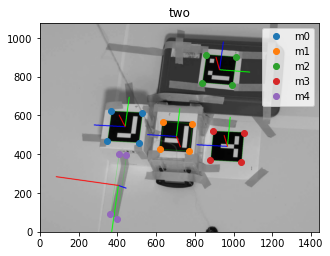

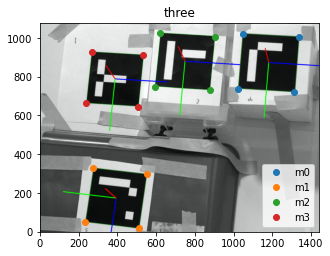

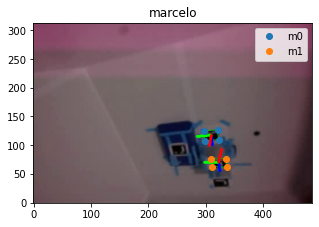

In [5]:
# reproject the point to be sure
for camera, areg in aruco_registration.items():
    plt.figure(figsize=(5,5))
    plt.subplot(1,1,1)
    img = load_one_frame(vid_files[camera], 1)
    img=aruco.drawDetectedMarkers(img, areg['corners'])  # Draw A square around the markers

    corner_markers = 'osd*'
    colors = 'rgbyk'
    for ipts in range(len(areg['corners'])):
        pts = areg['corners'][ipts]
        rv = areg['rvec'][ipts]
        tv = areg['tvec'][ipts]

        img=aruco.drawAxis(img, 
                           cameraMatrix=areg['cam_calib']['mtx'], 
                           distCoeffs=areg['cam_calib']['dist'], 
                           rvec=rv, 
                           tvec=tv, 
                           length=50)  # Draw Axis
        campts, _ = cv2.projectPoints(areg['aruco_in_cam'][ipts], 
                                      rvec=np.zeros(3), 
                                      tvec=np.zeros(3), 
                                      cameraMatrix=areg['cam_calib']['mtx'], 
                                      distCoeffs=areg['cam_calib']['dist'])
        plt.plot(*campts[:,0,:].T, 'o', label='m%i'%(ipts))

    plt.imshow(img, origin='lower')
    plt.legend()
    plt.title(camera)


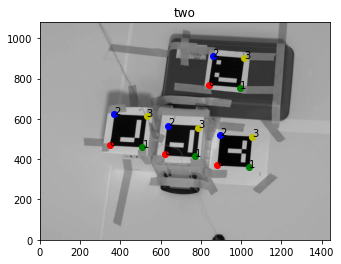

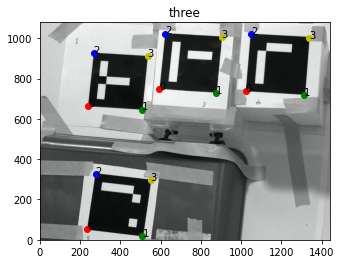

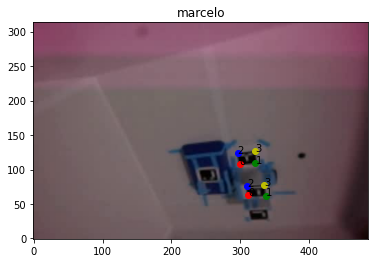

In [6]:
# find which is top right

markerorder_dict = dict(
    two=dict(one=3, two=2, three=1, four=0),
    three=dict(one=3, two=1, three=2, four=0),
    marcelo=dict(one=0,three=1))

for camera, areg in aruco_registration.items():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    gray = load_one_frame(vid_files[camera], 1)
    ax.imshow(gray, cmap='Greys_r', origin='lower', aspect='equal')

    colors = 'rgby'
    for name, im in markerorder_dict[camera].items():
        common = dict(aruco_detection_index=im, name=name)
        corners2d = areg['corners'][im][0]
        pos = (corners2d - np.mean(corners2d, axis=0)) > 0
        pos = pos[:, 0] + 2*pos[:,1]
        for c, p in zip(corners2d, pos):
            ax.plot(c[0], c[1], color=colors[p], marker='o')
            ax.text(c[0], c[1], str(p))
    plt.title(camera)
    

In [7]:
# create a dataframe with 2D and 3d coordinates of each marker corner, with proper name
pos_order_dict = dict(two=['br', 'bl','tr',  'tl'],
                     three=['tl', 'tr','bl',  'br'],
                     marcelo=['tr', 'br','tl',  'bl'])
all_dfs = {}
for camera, areg in aruco_registration.items():
    df = {}
    pos_text = pos_order_dict[camera]
    for name, im in markerorder_dict[camera].items():
        common = dict(aruco_detection_index=im, name=name)
        corners2d = areg['corners'][im][0]
        pos = (corners2d - np.mean(corners2d, axis=0)) > 0
        pos = pos[:, 0] + 2*pos[:,1]
        for ic, corners3d in enumerate(areg['aruco_in_cam'][im]):
            series = dict(common)
            series['corners3d'] = corners3d
            series['corners2d'] = areg['corners'][im][0][ic]
            series['position_index'] = pos[ic]
            series['position'] = pos_text[pos[ic]]
            df['marker_%s_corner_%s' % (name, pos_text[pos[ic]])] = series
    marker_df = pd.DataFrame(df).T
    all_dfs[camera] = marker_df

# Get HS points for each corner

In [8]:
def load_lighthouse(folder, take_median=True):
    fnames = folder.glob('lighthouse_matrix*.dat')
    out = {}
    for f in fnames:
        data = np.fromfile(folder / f, dtype='double')
        data = data.reshape(-1, 3)
        if take_median:
            data = np.nanmedian(data, axis=0)
        out[f.stem.split('_')[1][-1]] = data
    return out

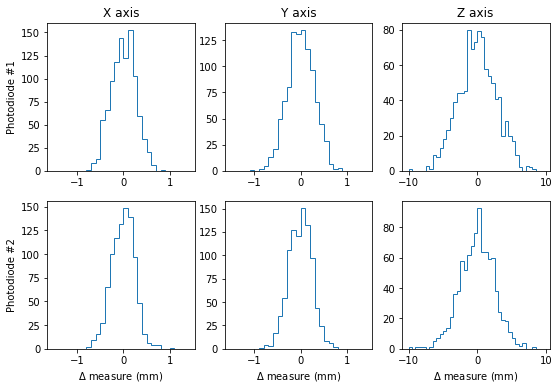

In [9]:
# check light house stability
fig, axes = plt.subplots(2,3)
fig.set_facecolor('white')
fig.set_size_inches((9,6))

# accumulate all the files
data = {k:[] for k in [1,2]}
for im, (mn, series) in enumerate(marker_df.iterrows()):
    marker = series['name']
    position = series.position
    folder = data_root.glob('aruco_%s*%s*'%(marker, position))
    marker_light_pts = {'1':dict(), '2':dict()}

    for f in folder:
        _, marker_name, pos_name = f.stem.split('_')
        assert marker_name == marker
        assert pos_name == position
        ldata = load_lighthouse(f, take_median=False)
        for il in [1, 2]:
            d = ldata[str(il)]
            d = (d - np.median(d, axis=0)) * 1000.
            data[il].append(d)
# plot all together
for il in [1, 2]:
    d = np.vstack(data[il])
    for iax in range(2):
        axes[il-1, iax].hist(d[:,iax], bins=np.arange(-1.5, 1.5, 0.1), histtype='step')
    axes[il-1, 2].hist(d[:,2], bins=np.arange(-10, 10, 0.5), histtype='step')
axes[0,0].set_ylabel('Photodiode #1')
axes[1,0].set_ylabel('Photodiode #2')
lab = ['X', 'Y', 'Z']
for x in range(3):
    axes[1,x].set_xlabel('$\Delta$ measure (mm)')
    axes[0,x].set_title('%s axis' % lab[x])

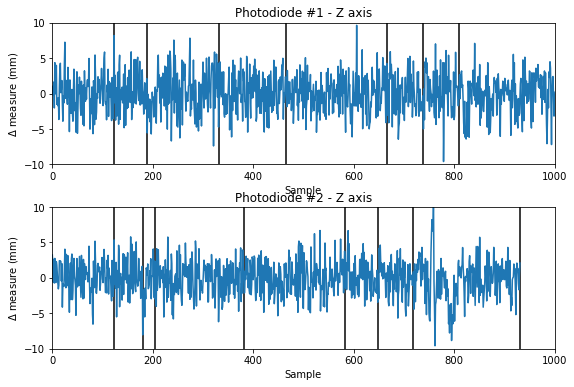

In [10]:
fig, axes = plt.subplots(2,1)
fig.set_facecolor('white')
fig.set_size_inches((9,6))
lab = ['X', 'Y', 'Z']
for il in [1, 2]:
    d = np.vstack(data[il])
    count = [len(part) for part in data[il]]
    for iax in [2]:
        axes[il-1].plot(d[:,iax])
        for c in np.cumsum(count):
            axes[il-1].axvline(c, color='k', zorder=-10)
axes[0].set_title('Photodiode #1 - %s axis' % lab[iax])
axes[1].set_title('Photodiode #2 - %s axis' % lab[iax])

for x in axes:
    x.set_xlim([0, 1000])
    x.set_ylim([-10, 10])
    x.set_ylabel('$\Delta$ measure (mm)')
    x.set_xlabel('Sample')

fig.subplots_adjust(hspace=0.3)

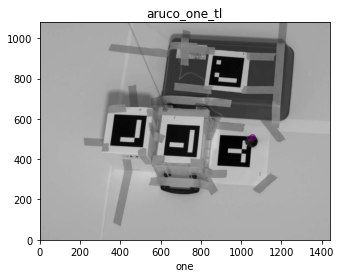

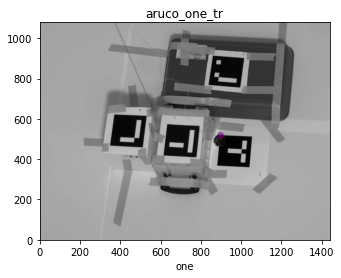

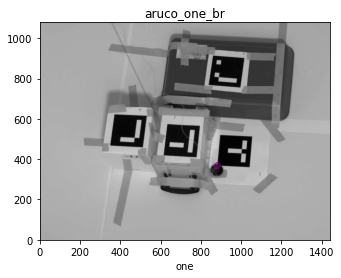

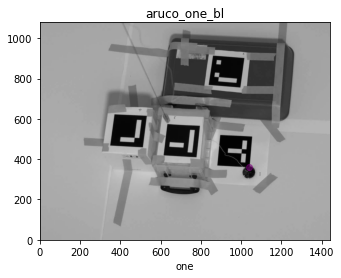

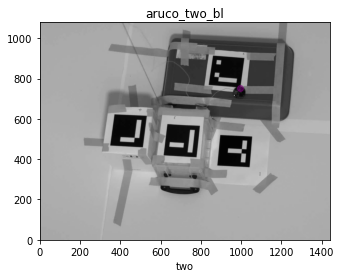

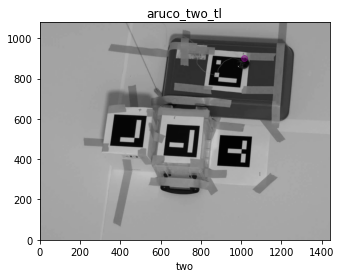

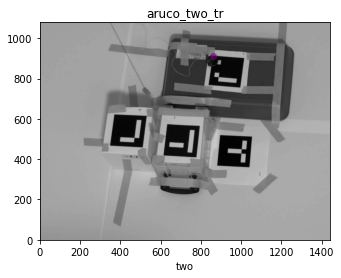

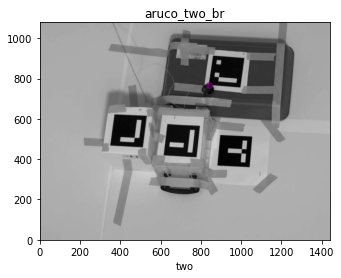

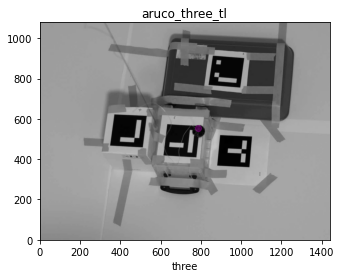

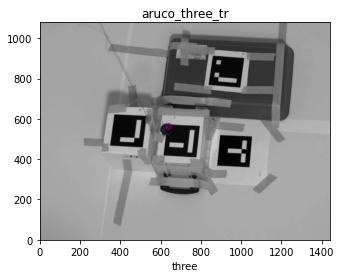

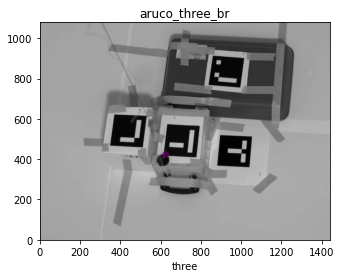

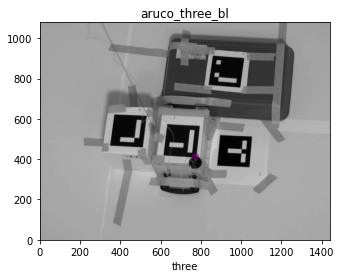

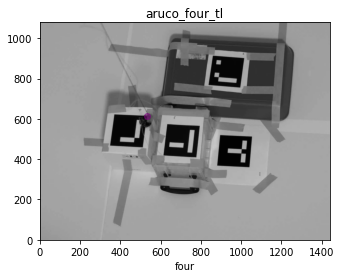

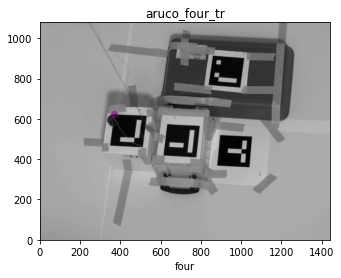

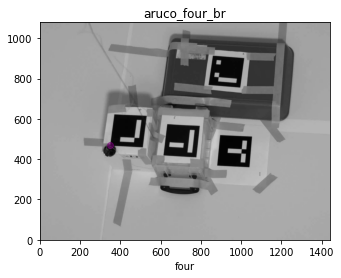

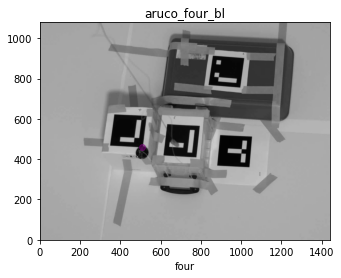

In [13]:
plot_check = True
for camera, areg in aruco_registration.items():
    marker_df = all_dfs[camera]
    marker_df['hs_position1'] = [np.zeros(3) + np.nan for i in range(marker_df.shape[0])]
    marker_df['hs_position2'] = [np.zeros(3) + np.nan for i in range(marker_df.shape[0])]
    for im, (mn, series) in enumerate(marker_df.iterrows()):
        marker = series['name']
        position = series.position
        folder = data_root.glob('aruco_%s*%s*'%(marker, position))
        marker_light_pts = {'1':dict(), '2':dict()}
        for f in folder:
            _, marker_name, pos_name = f.stem.split('_')
            assert marker_name == marker
            assert pos_name == position
            ldata = load_lighthouse(f)
            marker_df.loc['marker_%s_corner_%s' % (marker, position), 'hs_position1'][:] = ldata['1']
            marker_df.loc['marker_%s_corner_%s' % (marker, position), 'hs_position2'][:] = ldata['2']
            if plot_check:
                img = load_one_frame(list(f.glob('video_%s*.avi'%camera))[0], 1, return_gray=False)
                fig = plt.figure()
                plt.imshow(img, origin='lower')
                plt.title(f.stem)
                plt.xlabel(marker)
                s = marker_df.loc['marker_%s_corner_%s' % (marker, position)]
                plt.plot(*s.corners2d, 'o', color='purple', alpha=0.5)
            break
    break



# Transform lighthouse coordinates in camera

Just do linear regression between the two sets of 3d points

In [14]:
from sklearn.linear_model import LinearRegression

reg_linear = dict()
for camera, marker_df in all_dfs.items():
    campts = np.vstack(marker_df.corners3d)
    light1pts = np.vstack(marker_df.hs_position1)
    reg_cam_linear = LinearRegression().fit(light1pts, campts)
    reg_linear[camera] = reg_cam_linear

# Make a plot with the three camera and tracking

In [15]:
# get the data

movie_folder = data_root / 'example_mouse_aruco_reward'

# get path to video
vid_files = movie_folder.glob('video_*.avi')
vid_data = {}
for fname in vid_files:
    vid_data[fname.stem.split('_')[1]] = str(fname)

# get ligthhouse data
light_files = movie_folder.glob('lighthouse*.dat')
light_data = {}
for l in light_files:
    data = np.fromfile(l, dtype='double')
    data = data.reshape(-1, 3)
    light_data[l.stem.split('_')[1]] = data
    
# get timestamps for alignment
# load csv and center all bonsai csv datetime on the same zero
csv_files = movie_folder.glob('*.csv')
csv_data = {}
zero = None
for v in csv_files:
    k = '_'.join(v.stem.split('_')[:2])
    data = pd.read_csv(v, header=None)
    if k.startswith('camera_marcelo'):
        data = data[[data.columns[-1]]]
    if data.shape[1] == 2:
        data.columns = ['camera', 'bonsai']
    else:
        data.columns = ['bonsai']
    data['bonsai'] = pd.to_datetime(data.bonsai)
    if zero is None:
        zero = data.bonsai[0]
    data['bonsai'] = (data.bonsai - zero).dt.total_seconds()
    name = k.split('_timestamps')[0]
    csv_data[name] = data
    print('%s data point for %s'%(len(data), name))
    
# rotate the lighthouse in nicer coordinates for the last plot
lighthouse_calib = np.load(save_root /  'lighthouse_calibration.npz')

rot_light = dict()
for ilight in (1, 2):
    raw_data = light_data['matrix%d'%ilight]
    centered = raw_data - lighthouse_calib['origin']
    rotated = np.array(np.matmul(lighthouse_calib['A_light2world'], centered.T).T)
    rot_light[ilight] = rotated

110499 data point for camera_two
28820 data point for lighthouse2
13817 data point for lighthouse1
310847 data point for camera_marcelo
110530 data point for camera_three


In [22]:
d = rot_light[2]

3.6999999999999993

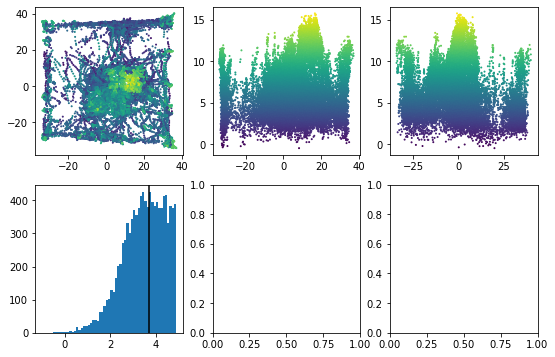

In [35]:
fig, axes = plt.subplots(2, 3)
fig.set_facecolor('white')
fig.set_size_inches(9,6)

d = d[d[:,2] <30]
axes[0, 0].scatter(d[:,0], d[:,1], c=d[:,2],s=1)
axes[0,1].scatter(d[:,0], d[:,2], c=d[:,2],s=1)
axes[0,2].scatter(d[:,1], d[:,2], c=d[:,2],s=1)

n,b,p =axes[1,0].hist(d[d[:,2] < 5,2], bins=np.arange(-1,5, 0.1))
axes[1,0].axvline(b[n.argmax()], color='k')
b[n.argmax()]


In [39]:
3.7-1.8/np.arccos(np.deg2rad(20))

2.2175695946149903

In [66]:

light_tss = [csv_data['lighthouse%i'%il].bonsai.values for il in [1,2]]
np.argmax([len(i) for i in light_tss])

# keep only the relevant part

1

In [ ]:
from matplotlib import animation

movie_folder = data_root / 'example_mouse_aruco_reward'
begin = 300
end = 360 # 420

light_tss = [csv_data['lighthouse%i'%il].bonsai.values for il in [1,2]]
master_tss = light_tss[np.argmax([len(i) for i in light_tss])]

# keep only the relevant part
master_tss = master_tss[(master_tss > begin) & (master_tss <= end)]

# find axis limit for lighthouse data
axmin = np.min([np.min(d[(light_tss[il-1]>begin) &(light_tss[il-1]<=end)], axis=0) 
                for il, d in rot_light.items()], axis=0)
axmax = np.max([np.max(d[(light_tss[il-1]>begin) &(light_tss[il-1]<=end)], axis=0) 
                for il, d in rot_light.items()], axis=0)

print('%d time steps to plot' % len(master_tss))

fig = plt.figure(figsize=(10,10), facecolor='white')
axes = {camera: fig.add_subplot(2,2,i+1) for i, camera in enumerate(['marcelo', 'two', 'three'])}
axes['lighthouse'] = fig.add_subplot(2,2,4, projection='3d')

origin = dict(marcelo='upper', two='lower', three='upper')
transform = dict(marcelo=lambda x : x, #np.transpose(x[:,::-1]), 
                 two=lambda x: x[:,::-1], 
                 three=lambda x:x)
cap_data = {camera: cv2.VideoCapture(vid_data[camera]) for camera in vid_data.keys()}
fig.subplots_adjust(wspace=0.01, hspace=0)

def func(frame):
    ts = master_tss[frame]
    [x.clear() for x in axes.values()]
    # first plot the lighthouse in 3d
    for il, lts in enumerate(light_tss):
        b,e = lts.searchsorted([np.max([begin, ts-10]), ts])
        data = rot_light[il +1][b:e+1,:]
        if il == 1:
            axes['lighthouse'].plot(*data.T, color='k')
        axes['lighthouse'].plot(*data[-1,:].T, 'o')
    axes['lighthouse'].set_xlim([axmin[0], axmax[0]])
    axes['lighthouse'].set_ylim([axmin[1], axmax[1]])
    axes['lighthouse'].set_zlim([axmin[2], axmax[2]])

    for camera, areg in aruco_registration.items():
        cap = cap_data[camera]
        frame_tss = csv_data['camera_%s'%camera]
        frame_index = frame_tss.bonsai.searchsorted(ts)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        axes[camera].imshow(transform[camera](gray), origin=origin[camera], cmap='Greys_r')
        axes[camera].set_axis_off()
        for il, lts in enumerate(light_tss):
            b,e = lts.searchsorted([np.max([begin, ts-10]), ts])
            # now find the lighthouse data in the frame
            light3d_raw = light_data['matrix%i'%(il+1)][b:e+1]
            light3d = reg_linear[camera].predict(light3d_raw)
            # project on 2D
            lightonscreen, jac = cv2.projectPoints(light3d[np.newaxis,:, :],
                                                   rvec=np.zeros(3), 
                                                   tvec=np.zeros(3), 
                                                   cameraMatrix=areg['cam_calib']['mtx'], 
                                                   distCoeffs=areg['cam_calib']['dist'])
            # remove datapoint that are outside of the screen:
            lightonscreen[lightonscreen < 0] += np.nan
            lightonscreen[:,0,0][lightonscreen[:,0,0] > gray.shape[1]] += np.nan
            lightonscreen[:,0,1][lightonscreen[:,0,1] > gray.shape[0]] += np.nan
            if camera != 'two':
                if il == 1:
                    axes[camera].plot(lightonscreen[:,0,0],lightonscreen[:,0,1], 'purple', lw=1)
                axes[camera].plot(lightonscreen[-1,0,0],lightonscreen[-1,0,1], 'o', lw=1)
            else:
                if il == 1:
                    axes[camera].plot(gray.shape[1] - lightonscreen[:,0,0],lightonscreen[:,0,1], 'k', lw=1)
                axes[camera].plot(gray.shape[1] - lightonscreen[-1,0,0],lightonscreen[-1,0,1], 'o', lw=1)



# 
anim = animation.FuncAnimation(fig, func, frames=len(master_tss))
anim.save(save_root / 'pretty_movie.mp4', fps=len(master_tss)/(end-begin), codec='jpeg2000')


In [121]:
light_data['matrix%i'%(il +1)].shape

(28820, 3)

## plot on a movie

110530 frames
7919 in video
Doing frame 19900
Doing frame 20000
Doing frame 20100
Doing frame 20200
Doing frame 20300
Doing frame 20400
Doing frame 20500
Doing frame 20600
Doing frame 20700
Doing frame 20800
Doing frame 20900
Doing frame 21000
Doing frame 21100
Doing frame 21200
Doing frame 21300
Doing frame 21400
Doing frame 21500
Doing frame 21600
Doing frame 21700
Doing frame 21800
Doing frame 21900
Doing frame 22000
Doing frame 22100
Doing frame 22200
Doing frame 22300
Doing frame 22400
Doing frame 22500
Doing frame 22600
Doing frame 22700
Doing frame 22800
Doing frame 22900
Doing frame 23000
Doing frame 23100
Doing frame 23200
Doing frame 23300
Doing frame 23400
Doing frame 23500
Doing frame 23600
Doing frame 23700
Doing frame 23800
Doing frame 23900
Doing frame 24000
Doing frame 24100
Doing frame 24200
Doing frame 24300
Doing frame 24400
Doing frame 24500
Doing frame 24600
Doing frame 24700
Doing frame 24800
Doing frame 24900
Doing frame 25000
Doing frame 25100
Doing frame 25200


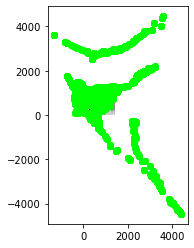

In [15]:
# and plot it on the movie
begin = 300
end = 420


dotsize = dict(two=12, marcelo=4, three=12)
cam_calib = dict(np.load(save_root / ('camera_%s_calibration.npz'%camera)))
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = None

# load one frame to get the size
frame = load_one_frame(vid_data[camera], 1)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cap = cv2.VideoCapture(vid_data[camera])
frame_tss = csv_data['camera_%s'%camera]
light_tss = [csv_data['lighthouse%i'%il].bonsai.values for il in [1,2]]


kernel = np.ones([dotsize[camera], dotsize[camera]], dtype=int)

def add_dot(frame, xy, kernel, color=(255, 0, 0)):
    xs, ys = np.where(kernel)
    xs += xy[0]
    ys += xy[1]
    for x, y in zip(xs, ys):
        if (0<=x<frame.shape[1]) and (0<=y<frame.shape[0]):
            frame[y, x] = color
    return frame

nframes = len(frame_tss)
print('%d frames' % nframes)
todo, _ = np.where((frame_tss > begin) & (frame_tss<=end))
print('%d in video'%len(todo))
for frame_index in todo: #nframes-139):
    if out is None:
        out = cv2.VideoWriter(str(save_root / ('output_tracking_%s.mp4'%camera)), fourcc, len(todo)/(end-begin), 
                              (frame.shape[1],frame.shape[0]))


    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
    assert cap.isOpened()
    frame_timestamp = frame_tss.bonsai[frame_index]
    res, frame = cap.read()


    ax.imshow(frame, origin='lower')

    light_indices = [0,0]
    for il in range(2):
        tss = light_tss[il]
        light_index = tss.searchsorted(frame_timestamp)
        tdiff = tss[light_index] - frame_timestamp
        if abs(tss[light_index - 1] - frame_timestamp) < tdiff:
            light_index -= 1
        tdiff = tss[light_index] - frame_timestamp
        color = (255, 0, 125*il) if tdiff > 0.2 else (0, 255, 0)

        light3d_raw = light_data['matrix%i'%(il+1)][light_index]
        light3d = reg_cam_two.predict(light3d_raw[np.newaxis,:])
        # project on 2D
        lightonscreen, jac = cv2.projectPoints(light3d[np.newaxis,:, :],
                                               rvec=np.zeros(3), 
                                               tvec=np.zeros(3), 
                                               cameraMatrix=cam_calib['mtx'], 
                                               distCoeffs=cam_calib['dist'])
        ax.plot(lightonscreen[0,0,0], lightonscreen[0,0,1], color=np.array(color)/255, marker='o')
        xy = np.array(np.round(lightonscreen[0,0,:]), dtype=int)
        frame = add_dot(frame, xy, kernel, color)
    out.write(frame)
    if frame_index % 100 == 0:
        print('Doing frame %d' % frame_index)
out.release()
cap.release()

In [16]:
frame_tss.bonsai.searchsorted(tss.max())-nframes

-25